In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from itertools import product
from sklearn.preprocessing import label_binarize

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2842)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 400)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

400

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    #'subject_len': mail_dict['subject_len'],
                    #'body_len': mail_dict['body_len'],
                    #'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    #'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    #'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    #'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    #'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    #'return_path_match_from': mail_dict['return_path_match_from'],
                    #'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    #'Content-type': mail_dict['Content-type'],
                    #'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    #'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    #'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    #'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    #'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    #'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    #'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    #'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    #'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    #'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    #'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    #'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    #'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    #'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    #'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    #'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    #'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    #'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    #'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    #'has_defects': mail_dict['has_defects'],
                    #'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    #'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate your Office 365 account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE YAX-80-97157 Tom Jensen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem 3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice from Karen Laman.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-637290015585-228.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 7 Past Due Invoices.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- lmportant Message.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Erinnerung an die Rechnungszahlung.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Re-[1].eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Preview Secured Message!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Syncing Error - (4) Incoming failed mails..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- _INV#00044901.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Delivery complete for parcel # 30726375.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Hope all your Christmas dreams come true!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment issue 2.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Ship Notification, Tracking Number 0RRN19486604712021.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Voice message from WIRELESS CALLER +1 718-963-4062).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Ren Hart used Dropbox to share

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- ICBC Payment Remittance.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- File shared 11-21-2017 on behalf of Kim Willoughby.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Wrong Invoice   Address.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Scanned Document - (Past due Invoice-083821.Pdf & Contract_Agreements.PDF).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [SPAM] New payment notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Shipment Notification[2].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Division6.4 LLC share a document Via DOCUSIGN.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Office 365 Suspension.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Past due Invoice 

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment notice for invoice #1647302.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Recent payment notification to Carol Rusten.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Express Domestic.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Yоu hаvе thе tаlеnt tо роsе fоr thе саmеrа, dоn't bе nеrvоus..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Coseco Invoice IR1-52583.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- IMPORTANT MAIL.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Pay Invoice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice #9066829 from Lori Whitesides.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] IMPORTANT - William Olberding  Invitation to view..eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payroll Update.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Record of Account Transcript from June 13, 2018.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Shipment Notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Pay Invoice[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Awaiting for your confirmation.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Please pull invoice 969295.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Investment...eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your Walmart Order Confirmation - Order #57707.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- ACTION REQUIRED- Payment Approval.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- This tiny pill can change your life..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- WebEx meeting invitation- RMW Demo.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Upcoming San Diego Environmental Bootcamp.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 📎 5786 S Zante Circle -- Nov. 2017 Property Review.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Webinar- How to prepare for Colombia's 2019 e-Invoicing mandate.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- November Hyperion Cloud Webinar Series.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Presidio  March Madness Event at Dave & Buster’s  REGISTER NOW.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Minnesota Legislative Update.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 11 

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- See what Shark-Tank judges pick as #1 of all time.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Yard Signs Are Here!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Webinar- It's time to say goodbye to network file shares.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Colorado Microsoft, Java, SFDC, and Oracle Experts.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 8th Circ. Won't Revive UnitedHealth's $350M Insurance Feud.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Come Golf with AWN & Link Technologies!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- We Are AAU, ARE YOU!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] We can optimize your brain.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Can You Help Me, Please.eml
/U

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Happy Holiday Discount.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Get back in the sack again with more gumption.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Don't let IT be the reason behind slow business innovation.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] GOD BLESS YOU..................VICTORIA HUGHES.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- springkleinoralsurgery@secure.icoreexchange.com sent you a secure email.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Hiring Software and IT Programmers - Meeting Request.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- She lost a third of her body weight.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- to Jim Mcmillen.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Regist

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\]'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- MICHAEL! You are PRE-APPROVED!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Upcoming Webinar- Cloud Readiness & Migration Considerations.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- All You Pay is Shipping For These Free Beauty Samples..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Your preloaded Amazon card is available to unlock..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- With great sympathy.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Gartner Magic Quadrant for P&C Core Platforms in North America.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Hacked Account Do Not Open Docusign Document.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- GDPR consent- Please confirm your subscription with dacadoo.eml
/Users/worshamn/Documents/emailProject/IgnoreF

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Kate Edwards reaching out from Box (59389662).eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Can we connect.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Attention Required.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- News About Your Most Challenging Sales Enablement Problems.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Sign Up Today! Health Headliners pres. Eric Neufeld on Prosthetics.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Letters of Credit for Importers - Exporters.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Are you delivering what your customers need, when they need it.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Be Healthy. Drink Coffee. .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Secure] PAR CANCELLATI

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\H'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Workers' Compensation Pro-2018.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Shahin- Complete Agenda Announced - Register Today - Big Data Bootcamp Denver Sep 8-10 2017.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Don't Miss Out  AWS Summit - San Francisco.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Churchill Claims Newsletter- You are now unsubscribed.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Come Back to FSAstore.com for $10 Off on $50+ orders.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Agency for Video Brochures.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- F619 Transformation featuring LEXIE FENNELL (2017 FITTEST LOSER, F619 TEAM LEADER).eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Renee's Wednesday schedule.eml
/Users/worshamn/Docum

Convert cells that are not recognized as a number or just to get rid of float

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
target    784 non-null object
text      784 non-null object
dtypes: object(2)
memory usage: 12.3+ KB


In [11]:
df.text.iloc[50]

'Your recent payment notification to Oti Herrera Patricia Castillo,   This email is to inform you, that you have sent an instant payment of $3054.95 to Oti Herrera.  Allow up to 10 minutes for this transaction to post to your account.   Get your receipt here.     Chase. Unlike Your Bank    Warm Regards,  Daniel Anderson  Head of Bus Banking Customer Support     Please do not reply to this email address. You will not get a response.'

Create a function to clean the text

In [12]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Text the text cleaning

In [13]:
text = [
    "Validate your Office 365 account       You have a new message from the Microsoft Office team.  View Message ",
    "Invoice Problem Hello Jessica Rael,    Wasn’t lucky enough to get in touch with your the other day. Anyways, hopefully you can get back to me  about this invoice below.  Invoice Problem: http://hajnalattila.hu/Document/New-invoice-534677/    Thanks, Shannon Hazzard",
    "Not A law firms.",
    "test www.cnn.com. Candy land is my favorite workers comp www.google.com game",
    "LIBRARY: WWW.CLICWEB.ORG",
    "cschultz@ironwomancon.com sent you files via WeTransfer Get your files     Click 'Download images' to view images      cschultz@ironwomancon.com    sent you some files   1 file, 44.9 KB in total   Get your files        Download link  https://wetransfer.com/downloads/afe70c67af1520e3ea919cd4c21e958a20180521173535/b6d72890eb2c97f07608d369eec817a320180521173602/7a1e75    1 file  ironwomancon_invoice.html    To make sure our emails arrive, please add noreply@wetransfer.com   to your contacts  .  About WeTransfer     ・   Help     ・   Legal     ・   Report this transfer as spam  ",
]
clean_text(text, remove_stopwords=False)

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization


['validate your office   account        you have a new message from the microsoft office team   view message',
 'invoice problem hello jessica rael     be not lucky enough to get in touch with your the other day anyways hopefully you can get back to me   about this invoice below   invoice problem      thank shannon hazzard',
 'not a law firm',
 'test   candy land be my favorite worker comp   game',
 'library',
 '  send you file via wetransfer get your file      click download image to view image           send you some file     file   kb in total    get your file         download link        file   ironwomanconinvoicehtml     to make sure our email arrive please add     to your contact     about wetransfer      ・    help      ・    legal      ・    report this transfer as spam  ']

In [14]:
from time import time
t0 = time()
corpus = clean_text(
    df['text'], 
    remove_stopwords=False
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization
done in 12.468s


In [15]:
df['cleaned_text'] = pd.Series(corpus).values

In [16]:
df.sample(10,random_state=123)

,target,text,cleaned_text
384,ignore,"Barbara.jones shrink your belly, 1lb day You d...",barbarajone shrink your belly lb day you do no...
164,investigate,Payment to Transaction # 68M6WZF3N84J45K ...,payment to transaction mwzfnjk hi ama...
729,ignore,Unlock your Amazon gift card before midnight G...,unlock your amazon gift card before midnight g...
689,ignore,Letters of Credit for Importers - Exporters Lo...,letter of credit for importer exporter logo ...
200,investigate,100.net; s 161025; h=x-gm-message-state:date...,net s hxgmmessagestatedatefromtomessageid...
776,ignore,"Better Together, Nintex + Box Help, We've...",good together nintex box help we have...
476,ignore,Jim - quick question Jim - I would like to int...,jim quick question jim i would like to int...
378,investigate,ShareFile Message From: Scott Houge ShareFile ...,sharefile message from scott houge sharefile e...
565,ignore,hey there Hi friend!! Thank me another time I ...,hey there hi friend thank me another time i be...
392,ignore,Quality Pet Food Delivered Save $15 on on your...,quality pet food deliver save on on your fir...


Split the sample set into test and training sets

In [17]:
df_target = df['target']
df_feats = df['cleaned_text']
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350
)

#### TFIDF Creation

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,4),
    #max_df=0.9, 
    min_df=2,
    use_idf=True
)
train_feats = vectorizer.fit_transform(train_feats.values.tolist())
test_feats = vectorizer.transform(test_feats.values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 1.440s


In [19]:
train_feats.shape

(627, 21950)

In [20]:
test_feats.shape

(157, 21950)

In [21]:
train_labels.value_counts()

ignore         318
investigate    309
Name: target, dtype: int64

Function to keep track of scoring and for printing results out

In [22]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    try:
        already_seen = clf.score(train_feats, train_labels)
        accuracy = clf.score(test_feats, test_labels)
        pred = clf.predict(test_feats)
    except:
        already_seen = clf.score(train_feats.toarray(), train_labels)
        accuracy = clf.score(test_feats.toarray(), test_labels)
        pred = clf.predict(test_feats.toarray())
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('False Negatives: %0d' % FN)
    return score_dict

#### SVM

In [23]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svm_clf)

done in 0.014s
LinearSVC Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9554
F1 score: 0.9530
False Negatives: 4


In [24]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svmr_clf)

done in 0.597s
SVC Scores:

Accuracy of data already seen: 0.5072
Accuracy of data not seen: 0.5223
F1 score: 0.0000
False Negatives: 75


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Extra Trees Classifier

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,et_clf)

done in 0.392s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9554
F1 score: 0.9530
False Negatives: 4


Get Feature Importances

In [26]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. unsubscribe (0.012286)
2. to (0.008513)
3. in (0.007750)
4. or (0.006500)
5. invoice (0.006276)
6. their (0.005320)
7. and (0.004907)
8. how (0.004856)
9. solution (0.004666)
10. can (0.004565)
11. be (0.004464)
12. like (0.004391)
13. at (0.004252)
14. work (0.004104)
15. how to (0.003987)
16. more (0.003886)
17. want to (0.003798)
18. what (0.003610)
19. that (0.003579)
20. make (0.003360)
21. attach (0.003279)
22. read more (0.003096)
23. it (0.002993)
24. start (0.002907)
25. one (0.002853)


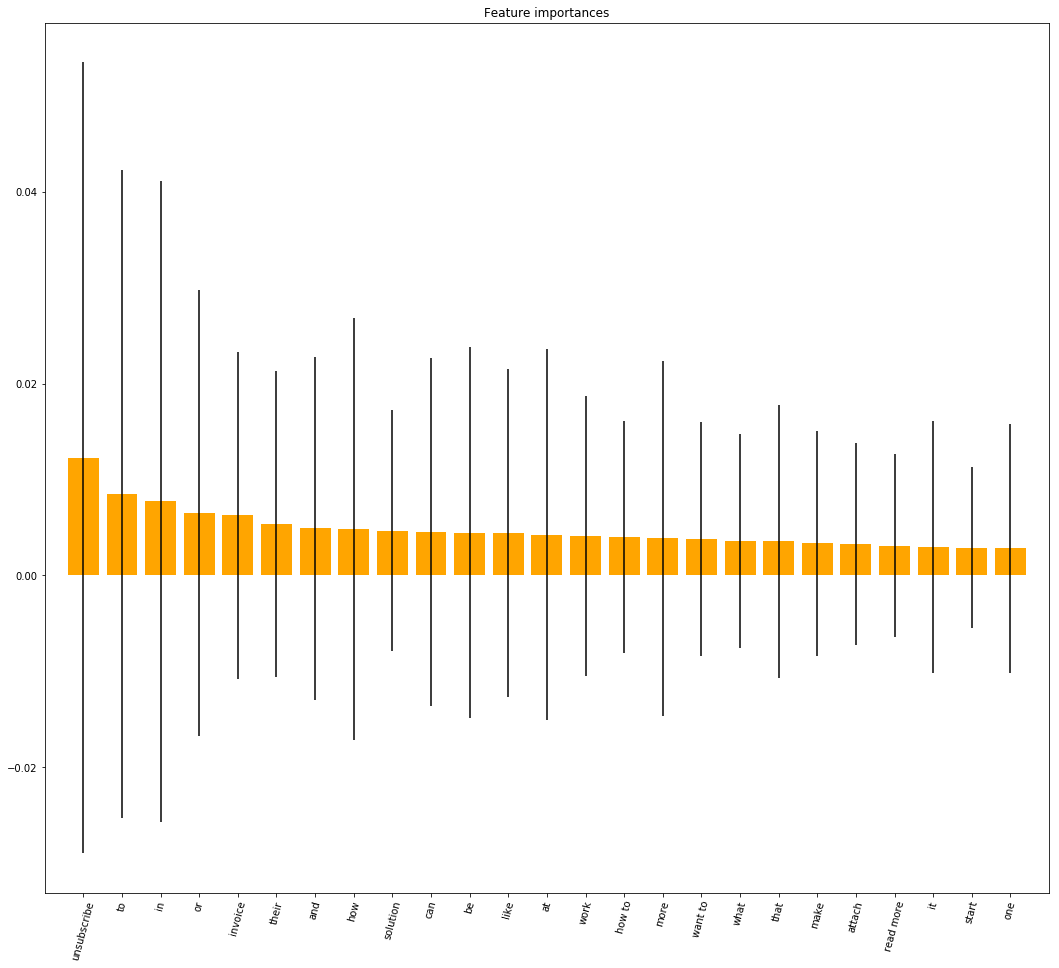

In [27]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gb_clf)

done in 4.128s
GradientBoostingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9299
F1 score: 0.9290
False Negatives: 3


#### XGBoost

In [29]:
from xgboost import XGBClassifier
t0 = time()
xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
xgb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,xgb_clf)

done in 3.573s
XGBClassifier Scores:

Accuracy of data already seen: 0.9936
Accuracy of data not seen: 0.9236
F1 score: 0.9211
False Negatives: 5


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Neural Net

In [30]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 28.787s
MLPClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9745
F1 score: 0.9733
False Negatives: 2


#### Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB
t0 = time()
nb_clf = MultinomialNB(alpha=.001)
nb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nb_clf)

done in 0.005s
MultinomialNB Scores:

Accuracy of data already seen: 0.9952
Accuracy of data not seen: 0.9745
F1 score: 0.9730
False Negatives: 3


In [32]:
from sklearn.naive_bayes import GaussianNB
t0 = time()
gnb_clf = GaussianNB()
gnb_clf.fit(train_feats.toarray(), train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gnb_clf)

done in 0.587s
GaussianNB Scores:

Accuracy of data already seen: 0.9952
Accuracy of data not seen: 0.8981
F1 score: 0.8806
False Negatives: 16


#### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rf_clf)

done in 0.436s
RandomForestClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9172
F1 score: 0.9150
False Negatives: 5


In [34]:
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. unsubscribe (0.012286)
2. to (0.008513)
3. in (0.007750)
4. or (0.006500)
5. invoice (0.006276)
6. their (0.005320)
7. and (0.004907)
8. how (0.004856)
9. solution (0.004666)
10. can (0.004565)
11. be (0.004464)
12. like (0.004391)
13. at (0.004252)
14. work (0.004104)
15. how to (0.003987)
16. more (0.003886)
17. want to (0.003798)
18. what (0.003610)
19. that (0.003579)
20. make (0.003360)
21. attach (0.003279)
22. read more (0.003096)
23. it (0.002993)
24. start (0.002907)
25. one (0.002853)


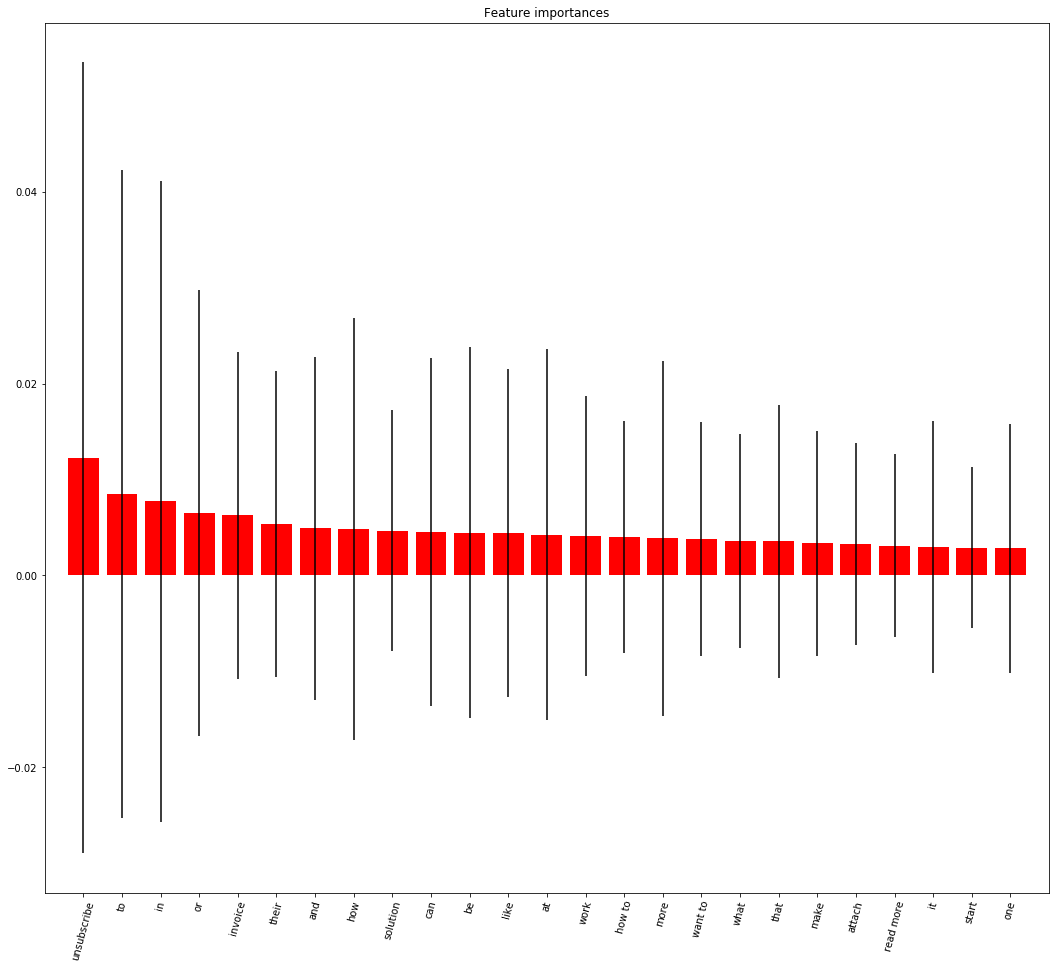

In [35]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [36]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,knn_clf)

done in 0.004s
KNeighborsClassifier Scores:

Accuracy of data already seen: 0.9553
Accuracy of data not seen: 0.9363
F1 score: 0.9359
False Negatives: 2


#### NearestCentroid

In [37]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nc_clf)

done in 0.016s
NearestCentroid Scores:

Accuracy of data already seen: 0.9426
Accuracy of data not seen: 0.9363
F1 score: 0.9324
False Negatives: 6


#### AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,ab_clf)

done in 1.204s
AdaBoostClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9045
F1 score: 0.9007
False Negatives: 7


#### QuadraticDiscriminantAnalysis

In [39]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
t0 = time()
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(train_feats.toarray(), train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,qda_clf)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.980s
QuadraticDiscriminantAnalysis Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.5732
F1 score: 0.4071
False Negatives: 52


#### GaussianProcessClassifier

In [40]:
from sklearn.gaussian_process import GaussianProcessClassifier
t0 = time()
gp_clf = GaussianProcessClassifier(random_state=7350)
gp_clf.fit(train_feats.toarray(), train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gp_clf)

done in 12.720s
GaussianProcessClassifier Scores:

Accuracy of data already seen: 0.9713
Accuracy of data not seen: 0.9363
F1 score: 0.9324
False Negatives: 6


#### Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,dt_clf)

done in 0.301s
DecisionTreeClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8790
F1 score: 0.8805
False Negatives: 5


#### LogisticRegression

In [42]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,lr_clf)

done in 0.052s
LogisticRegression Scores:

Accuracy of data already seen: 0.9697
Accuracy of data not seen: 0.9427
F1 score: 0.9396
False Negatives: 5


#### PassiveAggressiveClassifier

In [43]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,pa_clf)

done in 0.015s
PassiveAggressiveClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9682
F1 score: 0.9660
False Negatives: 4


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### RidgeClassifier

In [44]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rd_clf)

done in 0.083s
RidgeClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9554
F1 score: 0.9530
False Negatives: 4


#### SGDClassifier

In [45]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,sgd_clf)

done in 0.004s
SGDClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9618
F1 score: 0.9589
False Negatives: 5


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### CalibratedClassifierCV

In [46]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,cc_clf)

done in 0.060s
CalibratedClassifierCV Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9554
F1 score: 0.9517
False Negatives: 6


#### BaggingClassifier

In [47]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,bg_clf)

done in 4.543s
BaggingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9172
F1 score: 0.9150
False Negatives: 5


#### VotingClassifier

In [48]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
     ('nn',nn_clf),
    ('nb',nb_clf),
#     ('et',et_clf),
#     ('sgd',sgd_clf),
     ('svm',svm_clf),
#     ('pa',pa_clf),
#      ('nc',nc_clf),
#      ('knn',knn_clf),
#      ('cc',cc_clf),
#     ('rd',rd_clf),
#      ('rf',rf_clf),
])
vt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 27.848s


In [49]:
already_seen = vt_clf.score(train_feats, train_labels)
accuracy = vt_clf.score(test_feats, test_labels)
vt_pred = vt_clf.predict(test_feats)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('False Negatives: %0d' % FN)

VotingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9682
F1 score: 0.9664
False Negatives: 3


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [50]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

MLPClassifier: 0.9745
MultinomialNB: 0.9745
PassiveAggressiveClassifier: 0.9682


Best F1 Score:

MLPClassifier: 0.9733
MultinomialNB: 0.9730
PassiveAggressiveClassifier: 0.9660


Best False Negative Classifier:

MLPClassifier: 2
KNeighborsClassifier: 2
GradientBoostingClassifier: 3


#### Confusion Matrix and ROC curves of Top Algos

In [51]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()

In [53]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

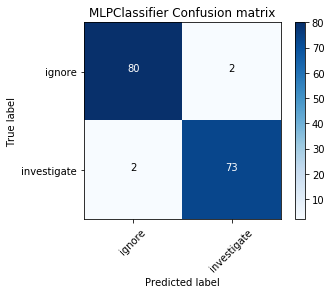

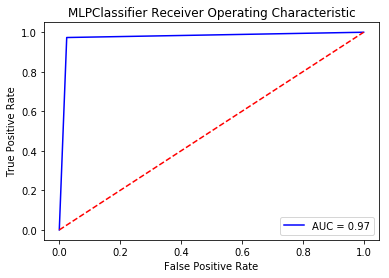

In [55]:
display_conf_mat(nn_clf,test_feats,test_labels)
plot_roc_curve(nn_clf,test_feats,test_labels)

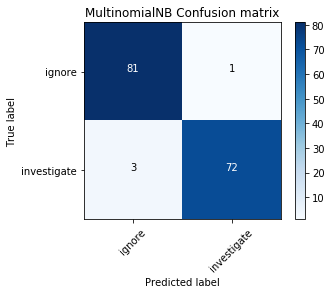

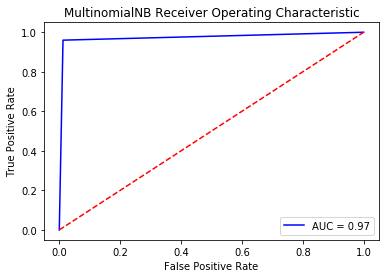

In [56]:
display_conf_mat(nb_clf,test_feats,test_labels)
plot_roc_curve(nb_clf,test_feats,test_labels)

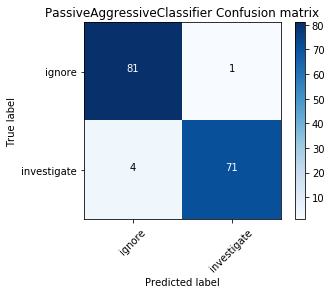

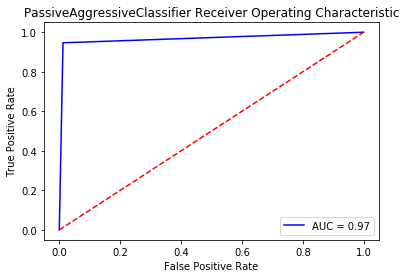

In [57]:
display_conf_mat(pa_clf,test_feats,test_labels)
plot_roc_curve(pa_clf,test_feats,test_labels)